In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf
from vit_pytorch import ViT

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for i in range(len(labels_df)):
#     minid = abs(events_df["timestamp"]-labels_df.iloc[i]["timestamp"]).idxmin()
#     labels_df["events_start_idx"][i] = minid
# labels_df.to_pickle("event_indexed_labels.pickle")
# DANGER: takes ~ 40 minutes

In [3]:
class EventDataset(Dataset):
    def __init__(self, data_dir, label_file, label_delta_len):
        events_cols=["timestamp", "x", "y", "polarity"]
        self.events_df = pd.read_csv(os.path.join(data_dir,"events.txt"), delimiter=' ', skiprows=1, names=events_cols)
        events_df_nostamp = self.events_df.loc[:, self.events_df.columns != 'timestamp']
        self.events_data = torch.from_numpy(events_df_nostamp.to_numpy(dtype=np.float32))
        
        self.labels_df = pd.read_pickle("event_indexed_labels.pickle")
        labels_df_nostamp = self.labels_df.loc[:, self.labels_df.columns != 'timestamp']
        labels_df_nostamp = labels_df_nostamp.loc[:, labels_df_nostamp.columns != 'events_start_idx']
        self.labels = torch.tensor(labels_df_nostamp.to_numpy(), dtype=torch.float32)

        self.delta = label_delta_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def __getitem__(self, idx):
        dpose = torch.zeros(7)
        l1 = self.labels[idx]
        l2 = self.labels[idx+self.delta]
        dl = l2-l1 # position delta
        dpose[:3] = dl[:3]
        q1 = l1[3:][[3,0,1,2]] # rearange quaternion, w goes first
        q2 = l2[3:][[3,0,1,2]] # rearange quaternion, w goes first
        dq = tf.quaternions.qmult(q2, tf.quaternions.qinverse(q1)) # orientation delta
        dpose[3:] = torch.tensor(dq, dtype=torch.float32) # pose delta is the label

        start = self.labels_df.iloc[idx]["events_start_idx"]
        finish = self.labels_df.iloc[idx+self.delta]["events_start_idx"]

        # could highly optimize this : )
        # torch version https://stackoverflow.com/questions/65584330/add-a-index-selected-tensor-to-another-tensor-with-overlapping-indices-in-pytorc/65584479#65584479
        events = np.array(self.events_data[int(start):int(finish)], dtype=np.uint16)
        mc = 400 # 345 is max dim
        img = np.zeros((mc,mc), dtype=np.float32)
        np.add.at(img,tuple([events[:,1], events[:,0]]), events[:,2] - .5)
        events = torch.tensor(img).unsqueeze(0)

        return events, dpose

    def set_label_delta(self, delta):
        self.delta = delta

data_dir = "indoor_forward_9_davis_with_gt"
vio_dataset = EventDataset(data_dir, "groundtruth.txt", 1)

(<matplotlib.image.AxesImage at 0x7fabe6c69790>, tensor(3.), tensor(-2.5000))

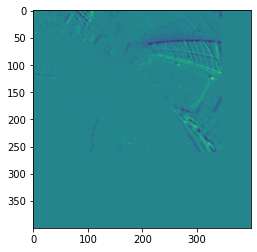

In [4]:
vio_dataset.set_label_delta(10)
events = vio_dataset.__getitem__(3000)[0].squeeze(0)
plt.imshow(events), events.max(), events.min()

In [5]:
# import time
# s = time.time()
# for i in range(len(vio_dataset)):
#     size = vio_dataset.__getitem__(i)[0].shape[0]
# (time.time() - s) / 1000 # per one sample, very quick

In [6]:
model = ViT(
    image_size = 400,
    patch_size = 40,
    num_classes = 7,
    dim = 32,
    depth = 6,
    heads = 8,
    mlp_dim = 64,
    dropout = 0.1,
    emb_dropout = 0.,
    channels=1
)

img = vio_dataset.__getitem__(1002)[0].unsqueeze(0) # batch 1

preds = model(img) # (1, 7)
preds

tensor([[-0.1977, -0.5712, -0.3167, -0.6765, -0.1829,  0.8369, -0.2863]],
       grad_fn=<AddmmBackward0>)

In [7]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=.25)
vio_dataset.set_label_delta(25) # SET THIS 10ish seems reasonable
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=128, shuffle=True, num_workers=8)
next(iter(dataloader))[0].shape

torch.Size([128, 1, 400, 400])

In [8]:
# # ### lr search : )
# lr = .01
# gamma = .5
# [lr*gamma**x for x in range(10)]

In [9]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')
        scheduler.step()

Epoch 0/39
----------
train Loss: 0.0349
Epoch 1/39
----------
train Loss: 0.0211
Epoch 2/39
----------
train Loss: 0.0172
Epoch 3/39
----------
train Loss: 0.0146
Epoch 4/39
----------
train Loss: 0.0126
Epoch 5/39
----------
train Loss: 0.0110
Epoch 6/39
----------
train Loss: 0.0093
Epoch 7/39
----------
train Loss: 0.0079
Epoch 8/39
----------
train Loss: 0.0080
Epoch 9/39
----------
train Loss: 0.0086
Epoch 10/39
----------
train Loss: 0.0065
Epoch 11/39
----------
train Loss: 0.0051
Epoch 12/39
----------
train Loss: 0.0048
Epoch 13/39
----------
train Loss: 0.0044
Epoch 14/39
----------
train Loss: 0.0032
Epoch 15/39
----------
train Loss: 0.0036
Epoch 16/39
----------
train Loss: 0.0037
Epoch 17/39
----------
train Loss: 0.0027
Epoch 18/39
----------
train Loss: 0.0020
Epoch 19/39
----------
train Loss: 0.0025
Epoch 20/39
----------
train Loss: 0.0024
Epoch 21/39
----------
train Loss: 0.0019
Epoch 22/39
----------
train Loss: 0.0016
Epoch 23/39
----------
train Loss: 0.0015
Ep

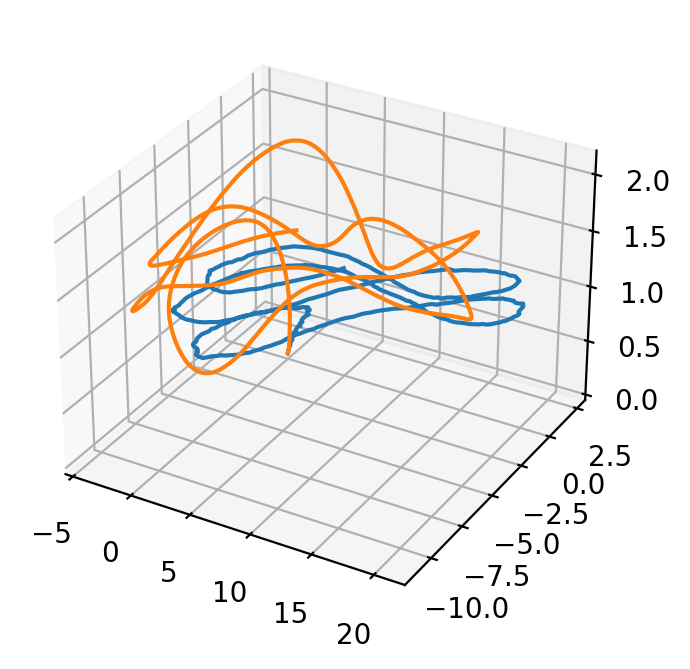

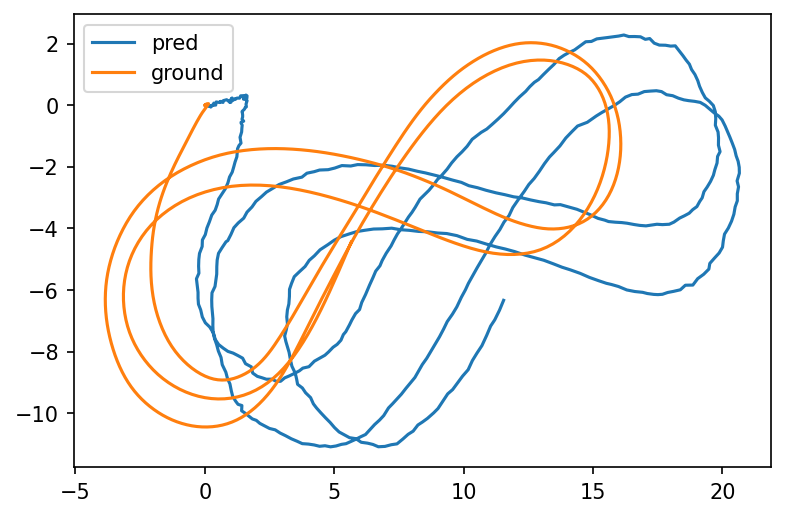

In [11]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(int(len(vio_dataset)/vio_dataset.delta)):
    data_point = vio_dataset.__getitem__(i*vio_dataset.delta)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])

plt.figure(2, dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])